In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.datasets import make_moons, fetch_covtype
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score,\
                      f1_score, precision_recall_curve, roc_curve, roc_auc_score, PrecisionRecallDisplay, RocCurveDisplay, average_precision_score
import seaborn as sns; sns.set()

Формуємо датасет make_moons та стандартизуємо його (масштабування+центрування). Розбиваємо датасет та візуалізуємо.

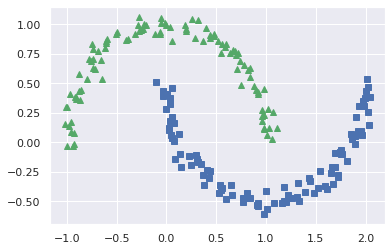

In [ ]:
def scaled_moons(noise, rand, n_samples):
  X, y = make_moons(noise=noise, random_state=rand, n_samples=n_samples)
  plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
  plt.plot(X[:, 0][y==0], X[:, 1][y==0], "g^")
  plt.show()
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)
  scaler = StandardScaler()
  scaler.fit(X_train)
  X_train = scaler.transform(X_train)
  X_test = scaler.transform(X_test)
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = scaled_moons(0.05, 1, 200)
# plt.plot(X_train[:, 0][y_train==1], X_train[:, 1][y_train==1], "bs")
# plt.plot(X_train[:, 0][y_train==0], X_train[:, 1][y_train==0], "g^")

LinearSVC та SVC з лінійним ядром для даних make_moons, задаємо велике С та тренуємо модель.
Обчислюємо метрики, зокрема accuracy (ефективна, бо датасет збалансований).

In [ ]:
def metrics(test, pred):
  '''
  precision: tp / (tp + fp), recall: tp / (tp + fn)
  F1 = 2 * (precision * recall) / (precision + recall)
  для даних метрик накраще значення 1, найгірше 0
  '''
  print("Правильність:", accuracy_score(test, pred))
  print("Точність:", precision_score(test, pred))
  print("Повнота:", recall_score(test, pred))
  print("F1:", f1_score(test, pred))
  mat = confusion_matrix(test, pred)
  sns.heatmap(mat, square=True, annot=True, cbar=False)

def PR_and_ROC_AUC(x_test, model):
  y_score=model.decision_function(x_test)
  prec, recall, _ = precision_recall_curve(y_test, model.decision_function(X_test),
                                          pos_label=model.classes_[1])
  pr_dspl = PrecisionRecallDisplay(precision=prec, recall=recall, average_precision=average_precision_score(y_test, y_score), estimator_name="LinearSVC").plot()

  fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=model.classes_[1])
  roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_score(y_test, y_score), estimator_name="LinearSVC").plot()


Правильність: 0.8625
Точність: 0.8666666666666667
Повнота: 0.8863636363636364
F1: 0.8764044943820225


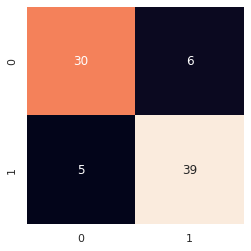

In [ ]:
# plt.plot(X_train[:, 0][y_train==1], X_train[:, 1][y_train==1], "bs")
# plt.plot(X_train[:, 0][y_train==0], X_train[:, 1][y_train==0], "g^")
plt.show()
clf = LinearSVC(C=1000, max_iter=20000, dual=False)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

metrics(y_test, y_pred)

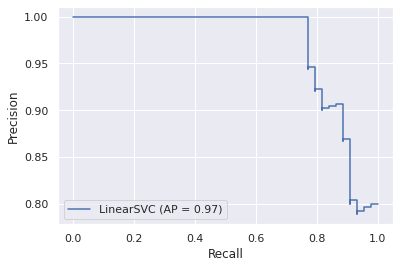

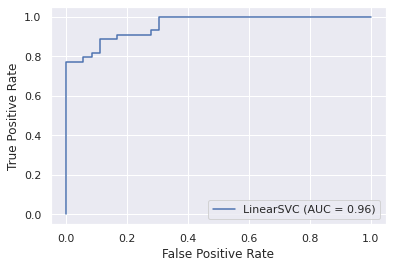

In [ ]:
PR_and_ROC_AUC(X_test, clf)

Функція для візуалізації опорних векторів в R^2



In [ ]:
def plot_vec(sample, model):
    plt.scatter(sample[:, 0], sample[:, 1], s=30, cmap=plt.cm.Paired)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                        np.linspace(ylim[0], ylim[1], 50))
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])

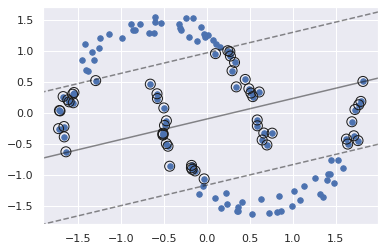

In [ ]:
# для моделі LinearSVC знаходимо опорні вектори
decision_function = clf.decision_function(X_train)
support_vector_indices = np.where(
    np.abs(decision_function) <= 1 + 1e-15)[0]
support_vectors = X_train[support_vector_indices]

plot_vec(X_train, clf)
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100,
            linewidth=1, facecolors='none', edgecolors='k')

Модель SVC з лінійним ядром розглянемо при малому шумі та більшому, коли дані частково перетинаються. У другому випадку встановимо маленьке С.

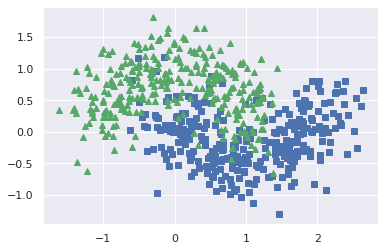

Правильність: 0.8416666666666667
Точність: 0.8545454545454545
Повнота: 0.8103448275862069
F1: 0.831858407079646


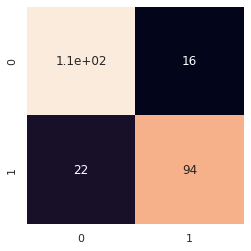

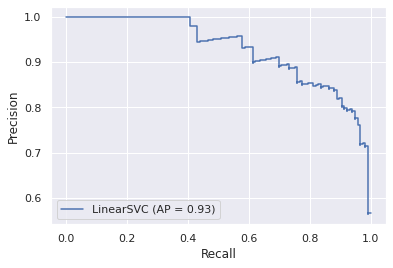

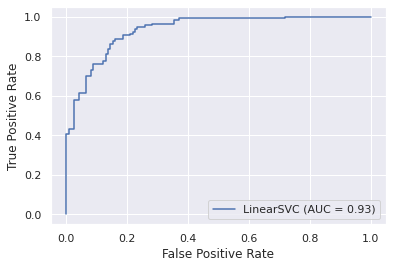

In [ ]:
X_train, X_test, y_train, y_test = scaled_moons(0.3, 42, 600)
lclf = SVC(kernel='linear', C=1)
lclf.fit(X_train, y_train)
y_pred = lclf.predict(X_test)

# графічно можемо побачити, чи є модель перенавченою
# y_pred = lclf.predict(X_train)
# plt.plot(X_train[:, 0][y_pred==1], X_train[:, 1][y_pred==1], "bs")
# plt.plot(X_train[:, 0][y_pred==0], X_train[:, 1][y_pred==0], "g^")
# plt.show()

metrics(y_test, y_pred)
PR_and_ROC_AUC(X_test, lclf)

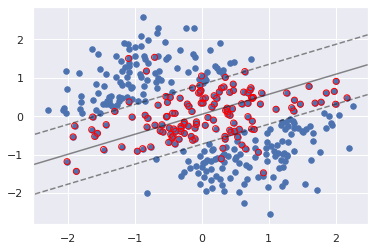

In [ ]:
plot_vec(X_train, lclf)
plt.scatter(lclf.support_vectors_[:, 0], lclf.support_vectors_[:, 1], linewidth=1, facecolors='none', edgecolors='red')

Досліджуємо модель з поліноміальним ядром та запускаємо решітчастий пошук.
Ядро: (γ(x,x')+coef0)^degree

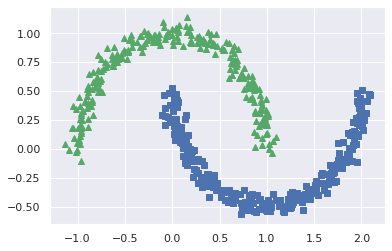

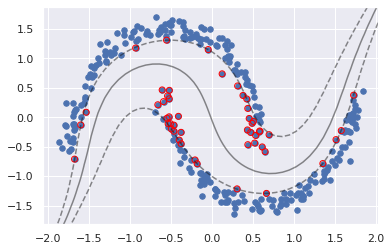

Правильність: 1.0
Точність: 1.0
Повнота: 1.0
F1: 1.0


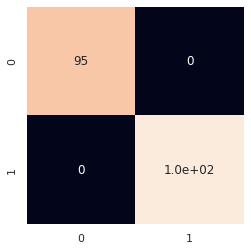

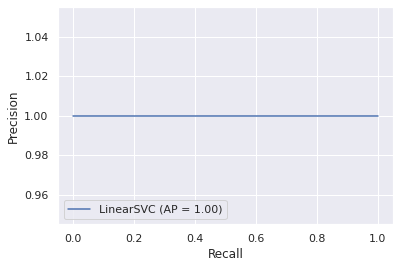

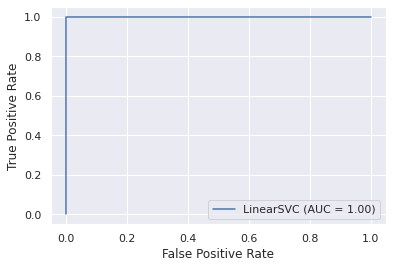

In [ ]:
X_train, X_test, y_train, y_test = scaled_moons(0.05, 1, 500)

pclf = SVC(kernel='poly', C=0.001, degree = 7, coef0=2)
pclf.fit(X_train, y_train)
plot_vec(X_train, pclf)
plt.scatter(pclf.support_vectors_[:, 0], pclf.support_vectors_[:, 1], linewidth=1, facecolors='none', edgecolors='red')
y_pred = pclf.predict(X_test)
plt.show()

metrics(y_test, y_pred)
PR_and_ROC_AUC(X_test, pclf)

Для датасету з гаусівським шумом (noise = 0.3) та n=500-кількістю прикладів GridSearchCV займає 4 хвилини, результат такий:
Найкраще значення перехресної перевірки:0.92
Правильність на тестовому наборі: 0.91
Найкращі параметри: {'svm__C': 1, 'svm__coef0': 2, 'svm__degree': 4}

In [ ]:
X, y = make_moons(noise=0.05, random_state=1, n_samples=500)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)
pipe = Pipeline([("scaler", StandardScaler()), ("svm", SVC(kernel='poly'))])

param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__degree': [2, 3, 4, 5, 6, 7],
              'svm__coef0': [-1, 0, 1, 2, 3, 4],
              'svm__probability': [True, False]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Найкраще значення перехресної перевірки:{:.2f}".format(grid.best_score_))
print("Правильність на тестовому наборі: {:.2f}".format(grid.score(X_test, y_test)))
print("Найкращі параметри: {}".format(grid.best_params_))


Найкраще значення перехресної перевірки:1.00
Правильність на тестовому наборі: 1.00
Найкращі параметри: {'svm__C': 0.001, 'svm__coef0': 2, 'svm__degree': 7, 'svm__probability': True}


Працюємо з датасетом fetch_covtype. Обираємо class_weight='balanced' та велике С

In [ ]:
Xf, yf = fetch_covtype(return_X_y=True)

In [ ]:
# Бачимо, що датасет не збалансований
# unique, counts = np.unique(yf, return_counts=True)
# np.asarray((unique, counts)).T

Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xf, yf, test_size=0.4, random_state=42)

scaler = StandardScaler()
scaler.fit(Xf_train)
Xf_train = scaler.transform(Xf_train)
Xf_test = scaler.transform(Xf_test)
clf = LinearSVC(C=100, max_iter=10000, dual=False, class_weight='balanced')
clf.fit(Xf_train, yf_train)
yf_pred = clf.predict(Xf_test)
multiclass_metrics(yf_test, yf_pred)

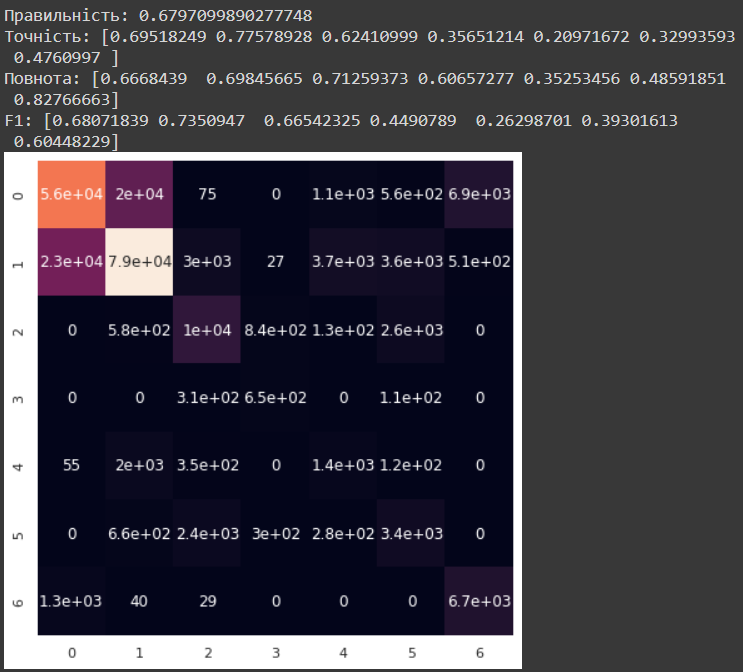

In [ ]:
def multiclass_metrics(test, pred):
  print("Правильність:", accuracy_score(test, pred))
  print("Точність:", precision_score(test, pred, average=None))
  print("Повнота:", recall_score(test, pred, average=None))
  print("F1:", f1_score(test, pred, average=None))
  mat = confusion_matrix(test, pred)
  plt.figure(figsize = (8,6))
  sns.heatmap(mat, square=True, annot=True, cbar=False)

In [ ]:
def plotPR(X, y, model):
  Y = label_binarize(y, classes=[1, 2, 3, 4, 5, 6, 7])
  n_classes = Y.shape[1]
  X_train, X_test, Y_train, Y_test = train_test_split(
      X, Y, test_size=0.4, random_state=42
  )

  classifier = OneVsRestClassifier(
      make_pipeline(StandardScaler(), model)
  )
  classifier.fit(X_train, Y_train)
  y_score = classifier.decision_function(X_test)

  precision = dict()
  recall = dict()
  average_precision = dict()
  for i in range(n_classes):
      precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
      average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

  # A "micro-average": quantifying score on all classes jointly
  precision["micro"], recall["micro"], _ = precision_recall_curve(
      Y_test.ravel(), y_score.ravel()
  )
  average_precision["micro"] = average_precision_score(Y_test, y_score, average="micro")


  # setup plot details
  colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

  _, ax = plt.subplots(figsize=(7, 8))

  f_scores = np.linspace(0.2, 0.8, num=4)
  lines, labels = [], []
  for f_score in f_scores:
      x = np.linspace(0.01, 1)
      y = f_score * x / (2 * x - f_score)
      (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
      plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

  display = PrecisionRecallDisplay(
      recall=recall["micro"],
      precision=precision["micro"],
      average_precision=average_precision["micro"],
  )
  display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

  for i, color in zip(range(n_classes), colors):
      display = PrecisionRecallDisplay(
          recall=recall[i],
          precision=precision[i],
          average_precision=average_precision[i],
      )
      display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

  # add the legend for the iso-f1 curves
  handles, labels = display.ax_.get_legend_handles_labels()
  handles.extend([l])
  labels.extend(["iso-f1 curves"])
  # set the legend and the axes
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.05])
  ax.legend(handles=handles, labels=labels, loc="best")
  ax.set_title("Extension of Precision-Recall curve to multi-class")
  plt.show()

In [ ]:
plotPR(Xf, yf, LinearSVC(C=100, max_iter=10000, dual=False, class_weight='balanced'))

Правильність: 0.6134
Точність: [0.68184282 0.79295689 0.66602687 0.256      0.11100833 0.36034483
 0.4203103 ]
Повнота: [0.68313875 0.53955794 0.55698234 0.68085106 0.75       0.69899666
 0.85878963]
F1: [0.68249017 0.64216349 0.60664336 0.37209302 0.19339243 0.47554039
 0.56439394]


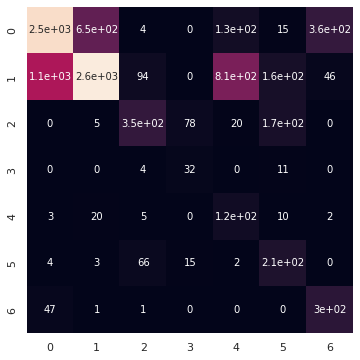

In [ ]:
Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xf, yf, train_size=10000, test_size=10000, random_state=42)
scaler = StandardScaler()
scaler.fit(Xf_train)
Xf_train = scaler.transform(Xf_train)
Xf_test = scaler.transform(Xf_test)

lclf = SVC(kernel='linear', C=1000, class_weight='balanced')
lclf.fit(Xf_train, yf_train)
yf_pred = lclf.predict(Xf_test)

multiclass_metrics(yf_test, yf_pred)

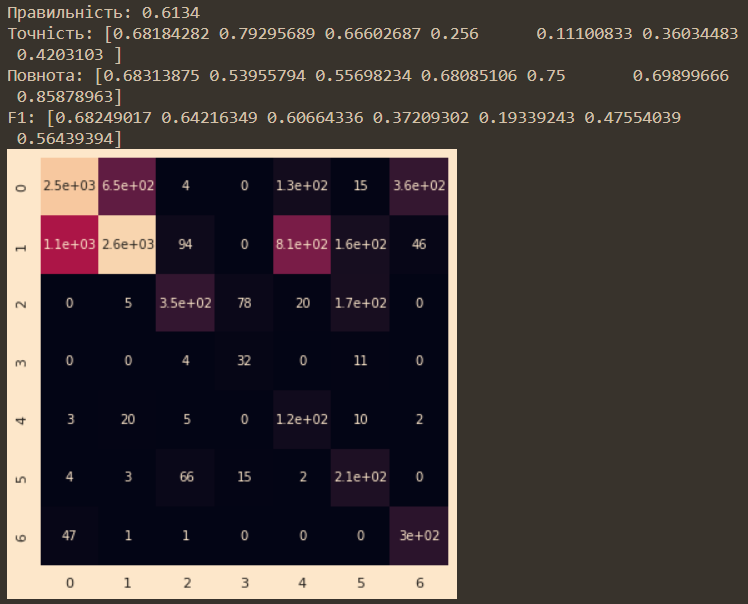

In [ ]:
Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xf, yf, train_size=30000, test_size=20000, random_state=42)
scaler = StandardScaler()
scaler.fit(Xf_train)
Xf_train = scaler.transform(Xf_train)
Xf_test = scaler.transform(Xf_test)

pclf = SVC(kernel='poly', C=1000, degree=4, class_weight='balanced', probability=True)

pclf.fit(Xf_train, yf_train)
y_pred = pclf.predict(Xf_test)
plt.show()

multiclass_metrics(yf_test, y_pred)
roc_auc_score(yf_test, pclf.predict_proba(Xf_test), multi_class='ovr')

Результати моделі з поліноміальним ядром:

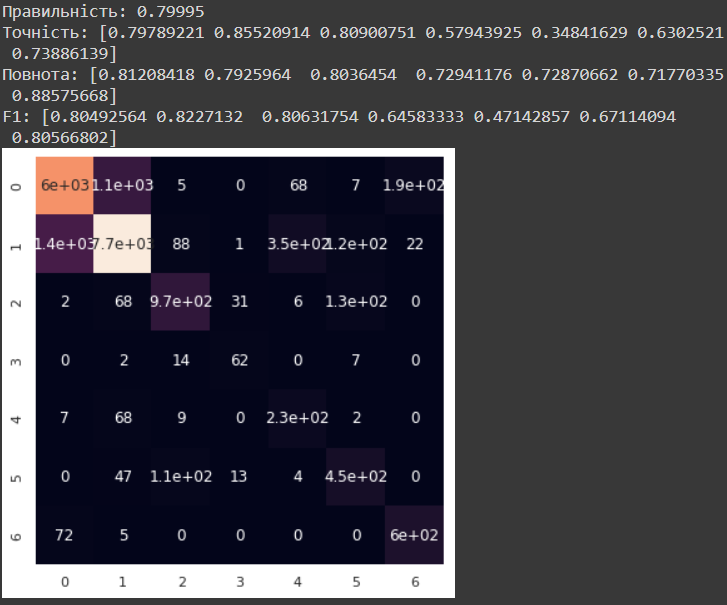

In [ ]:
Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xf, yf, train_size=20000, test_size=20000, random_state=42)
plotPR(Xf_train, yf_train, SVC(kernel='poly', C=1000, degree=4, class_weight='balanced'))

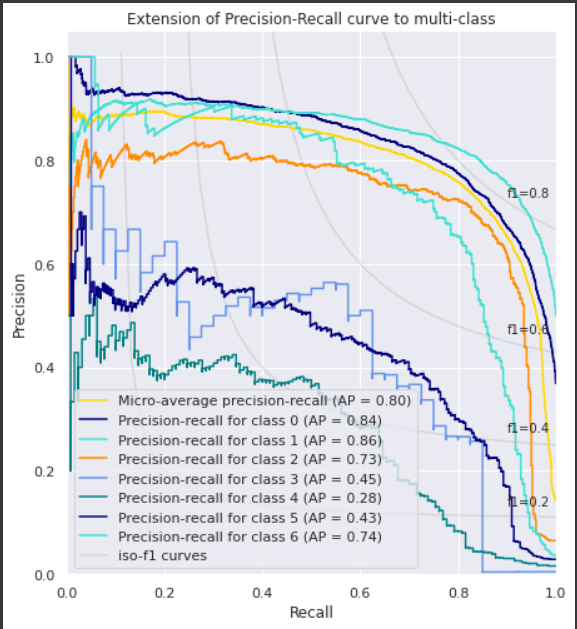

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Xf, yf, train_size=10000, test_size=10000, random_state=42)
pipe = Pipeline([("scaler", StandardScaler()), ("svm", SVC(kernel='poly', degree=4, class_weight='balanced'))])

param_grid = {'svm__C': [0.1, 1, 10, 100, 500, 1000],
              'svm__degree': [3, 4, 5, 6, 7],
              'svm__gamma': ['scale', 'auto']}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Найкраще значення перехресної перевірки:{:.2f}".format(grid.best_score_))
print("Правильність на тестовому наборі: {:.2f}".format(grid.score(X_test, y_test)))
print("Найкращі параметри: {}".format(grid.best_params_))

Отримали після решітчастого пошуку:
Найкраще значення перехресної перевірки:0.76
Правильність на тестовому наборі: 0.77
Найкращі параметри: {'svm__C': 1000, 'svm__degree': 4}